# Variability analysis for HBECs

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

import statsmodels.formula.api as smf
import statsmodels.api as sm
pd.set_option('display.max_rows', 600)

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [3]:
data_path = '/data_volume/memento/hbec/'
# fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Read ISG classes

In [9]:
isg_classes = pd.read_csv('../isg_classes.csv')
t1_isg = isg_classes.query('overall_type =="type1"').gene.tolist()
t2_isg = isg_classes.query('overall_type =="type2"').gene.tolist()
shared_isg = isg_classes.query('overall_type == "shared"').gene.tolist()
all_isg = isg_classes[isg_classes.sum(axis=1) > 0].gene.tolist()

In [10]:
len(all_isg)

494

### Read CHIP-seq data

In [41]:
enc = encode.Encode('/home/ssm-user/Github/misc-seq/miscseq/GRCh38Genes.bed')

In [ ]:
stat1_bed = enc.get_encode_peaks_union([
    'https://www.encodeproject.org/files/ENCFF747ICD/@@download/ENCFF747ICD.bed.gz',
    'https://www.encodeproject.org/files/ENCFF646MXG/@@download/ENCFF646MXG.bed.gz'
])
stat2_bed = enc.get_encode_peaks_union([
    'https://www.encodeproject.org/files/ENCFF204VQS/@@download/ENCFF204VQS.bed.gz',
    'https://www.encodeproject.org/files/ENCFF545JVD/@@download/ENCFF545JVD.bed.gz'
])

In [ ]:
intersect_bed = stat1_bed.intersect(stat2_bed).sort()

In [ ]:
isgf3_genes = enc.get_peak_genes_bed(intersect_bed, 0).query('distance == 0 & ~gene.str.contains("MT").values').gene.tolist()

### Read 1D HT results

In [6]:
cts = ['C', 'B', 'BC', 'all_ct']
tps = [ '3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [75]:
def read_result():
    
    ht_dict = {}
    moments_dict = {}
    
    for stim in stims:
        adata_subset = sc.read(data_path + '/binary_test_latest/C_{}_6.h5ad'.format(stim))
        ht_dict[stim] = memento.get_1d_ht_result(adata_subset)
        ht_dict[stim]['de_fdr'] = memento.util._fdrcorrect(ht_dict[stim]['de_pval'])
        ht_dict[stim]['dv_fdr'] = memento.util._fdrcorrect(ht_dict[stim]['dv_pval'])
        ht_dict[stim]= ht_dict[stim][(ht_dict[stim]['de_coef'].abs() < 100) & (ht_dict[stim]['dv_coef'].abs() < 100)]
#         moments_dict[stim] = memento.get_1d_moments(adata_subset, groupby='stim_indicator')
    return ht_dict,moments_dict

In [76]:
ht, moments = read_result()

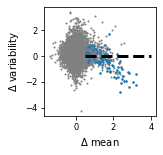

In [93]:
plt.figure(figsize=(2, 2))
plt.scatter(ht['beta']['de_coef'], ht['beta']['dv_coef'], s=1, color='grey')
plt.scatter(
    ht['beta'].query('gene in @isgf3_genes & de_coef > 0.5 & de_fdr < 0.05')['de_coef'], 
    ht['beta'].query('gene in @isgf3_genes & de_coef > 0.5 & de_fdr < 0.05')['dv_coef'], s=2)
plt.plot([0.5, 4], [0, 0], '--', lw=3, color='k')
plt.xlabel(r'$\Delta$ mean');plt.ylabel(r'$\Delta$ variability'); 
plt.savefig('de_vs_dv_tss_beta.png', bbox_inches='tight', dpi=500)

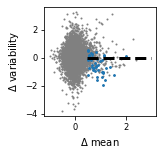

In [92]:
plt.figure(figsize=(2, 2))
plt.scatter(ht['gamma']['de_coef'], ht['gamma']['dv_coef'], s=1, color='grey')
plt.scatter(
    ht['gamma'].query('gene in @isgf3_genes & de_coef > 0.5 & de_fdr < 0.05')['de_coef'], 
    ht['gamma'].query('gene in @isgf3_genes & de_coef > 0.5 & de_fdr < 0.05')['dv_coef'], s=3)
plt.plot([0.5, 3], [0, 0], '--', lw=3, color='k')
plt.xlabel(r'$\Delta$ mean');plt.ylabel(r'$\Delta$ variability'); 
plt.savefig('de_vs_dv_tss_gamma.png', bbox_inches='tight', dpi=500)


### Variability over time

### Variability UMAP

In [26]:
ct = 'BC'
stim = 'beta'

In [27]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [28]:
converter = {'basal/club':'BC', 'basal':'B', 'ciliated':'C', 'goblet':'G', 'ionocyte/tuft':'IT', 'neuroendo':'N'}

In [29]:
adata.obs['ct'] = adata.obs['cell_type'].apply(lambda x: converter[x])
# adata_processed.obs['ct'] = adata_processed.obs['cell_type'].apply(lambda x: converter[x])

In [30]:
adata = adata[(adata.obs['ct'] == ct) & (adata.obs['stim'] == stim)].copy()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(8402, 36601)

In [32]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=40)
sc.tl.umap(adata)
